# Basic Part - Black and Scholes Model

## Utilities

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas_datareader as pdr

    
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

import math

SIGMA = 1
MASS = 1

DELTA_TIME = 0.01

DEFAULT_LENGTH = 10000

In [2]:
def normal_distrib(sigma=1, mean=0, count=1):
    return np.random.normal(mean, sigma, count)

In [3]:
def plot_stocks(stocks, name="Facebook"):
    days = list(range(1, len(stocks[0]) + 1))
    
    # plot all stocks
    for stock in stocks:
        plt.plot(days, stock)
        
    # output
    plt.xlabel("Time [Days]", fontsize=15)
    plt.ylabel("Price [USD]", fontsize=15)
    plt.legend(["Real"], fontsize=14)
    plt.show()

## Braunian Motion

In [4]:
def new_velocity(v_n):
    return v_n + DELTA_TIME * normal_distrib()[0]

def new_position(x_n, v_n):
    return x_n + v_n * DELTA_TIME

def general_eq(y_n, f_func, g_func):
    return y_n + f_func() * DELTA_TIME + g_func() * normal_distrib()[0]

In [5]:
def try_route(length=DEFAULT_LENGTH, init_vel=0):
    #v_0 = 0
    #x_0 = 0
    x_vector = [0] * length
    v_vector = [0] * length
    
    v_vector[0] = init_vel
    
    for i in range(1, length):
        v_vector[i] = new_velocity(v_vector[i-1])
        x_vector[i] = new_position(x_vector[i-1], v_vector[i-1])

    return x_vector, v_vector

def display_route_text(x_vec, v_vec):
    print("\n" + "~"*10)
    print("START:\t", str(x_vec[0]), "FINISH:\t", str(x_vec[-1]))
    print("Average speed:\t" + str(np.mean(v_vec)))
    print("Average position:\t" + str(np.mean(x_vec)))
    print("~"*10 + "\n")
    

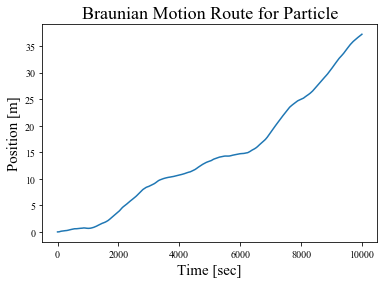

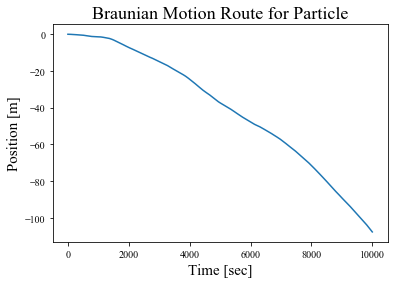

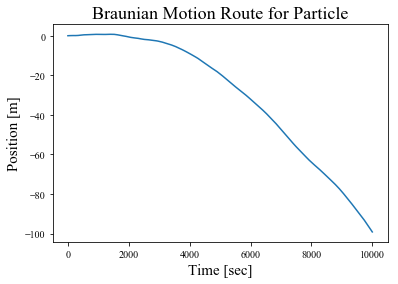

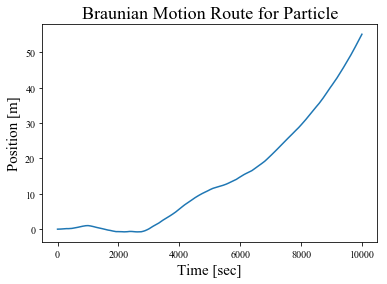

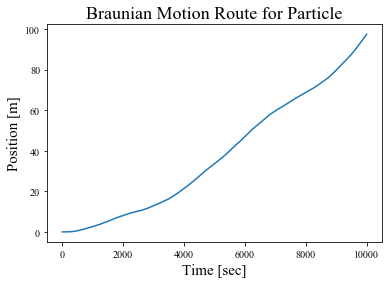

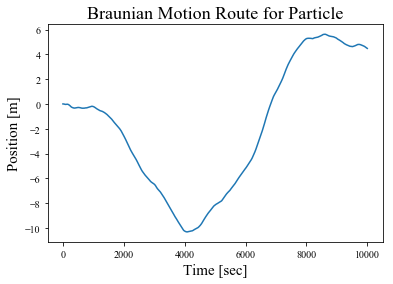

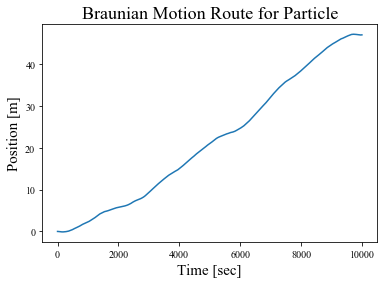

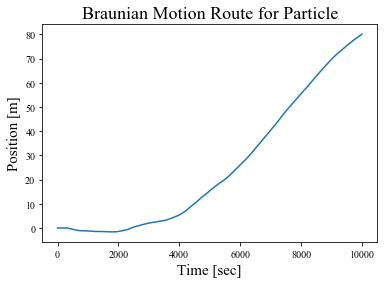

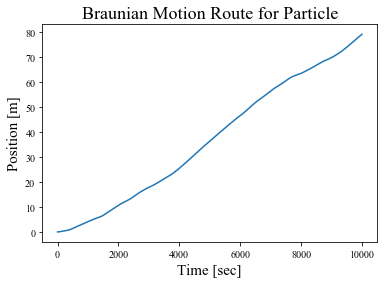

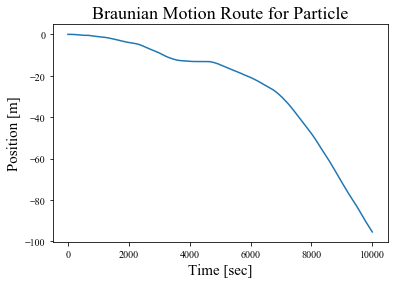

Average of average speeds:	 0.0981633485664
Average final location:	 9.81672304005


In [6]:
def braunian_motion(count=2, print_all=True):
    #np.random.seed(seed=31)
    
    overall_stats = {
        "average vels" : [],
        "pos" : [],        
    }
    for i in range(count):
        pos, vels = try_route()
        overall_stats["average vels"].append(np.mean(vels))
        overall_stats["pos"].append(pos[-1])
        
        if print_all:
            display_route_text(pos, vels)
            
        plt.plot(list(range(len(pos))), pos)
        plt.title("Braunian Motion Route for Particle", fontsize=18)
        plt.xlabel("Time [sec]", fontsize=15)
        plt.ylabel("Position [m]", fontsize=15)
        plt.show()
        
    print("Average of average speeds:\t", str(np.mean(overall_stats["average vels"])))
    print("Average final location:\t", str(np.mean(overall_stats["pos"])))
    
    
braunian_motion(10, False)

## Stock Simulation

In [7]:
data = pdr.DataReader("FB", "yahoo", "2016-01-01", "2017-01-01")
close_data = data['Close'].values

#log_r = math.log10(close_data[-1] / close_data[0]) / len(close_data)
#bad_way_for_r = math.pow(10, log_r)
#print(bad_way_for_r)

def get_norm_diffs(x):
    return (x[1:] - x[:-1]) / x[:-1] 

diffs = get_norm_diffs(close_data)
#print(ratios)
DEFAULT_R = np.mean(diffs)
DEFAULT_SIG = np.std(diffs)

print(DEFAULT_R)
print(DEFAULT_SIG)

0.000625570019147
0.0178045710841


In [8]:
def f_func(t, S, r=DEFAULT_R):
    return r * S

def g_func(t, S, sig=DEFAULT_SIG):
    return sig * S

In [9]:
def euler_maryuma(S_n, time_res, curr_time, r, sig):
    delta_w = normal_distrib(mean=0, sigma=math.sqrt(time_res))[0] 
    return (
        S_n 
        + f_func(curr_time, S_n, r) * time_res
        + g_func(curr_time, S_n, sig) * normal_distrib()[0]
    )

def milstein_scheme(S_n, time_res, curr_time, r, sig):
    delta_w = normal_distrib(mean=0, sigma=math.sqrt(time_res))[0] 
    return (
        S_n 
        + f_func(curr_time, S_n, r) * time_res
        + g_func(curr_time, S_n, sig) * delta_w        
        + 0.5 * g_func(curr_time, S_n, sig) * sig * (delta_w ** 2 - time_res)
    )

METHODS = {
    "em" : euler_maryuma,
    "ms" : milstein_scheme
}

In [10]:
# find the stock price based on 
# dS = f(t, S)dt + g(t, S)dE
# Explicitly:
# S_n+1 = S_n + f(t, S_n) * dt + g(t, S_n) * dE

def find_stock_price(S_0, r, sig, time_res, total_time, method="ms"):
    length = int(total_time / time_res)
    S =  [0] * length 
    S[0] = S_0
    
    for i in range(length-1):
        # curr_time Doesnt really matter cause f and g dont depend on T 
        # in the current model but for the sake of completeness
        curr_time = i * time_res
        
        #print(f_func(curr_time, S[i], r) * time_res)
        #print(g_func(curr_time, S[i], sig) * normal_distrib()[0])
        
        S[i+1] = METHODS[method](S[i], time_res, curr_time, r, sig)
    return(S)

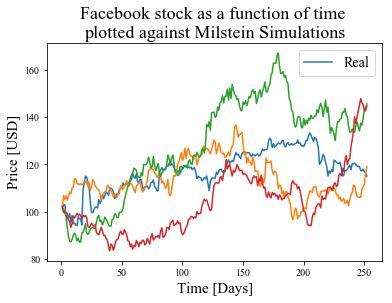

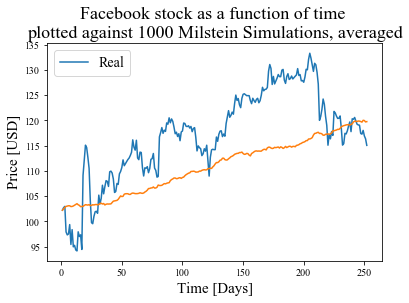

In [25]:
def simulate_prices(deterministic=True, simulations=100):
    ms_preds = []
    em_preds = []
    for i in range(simulations):
        if deterministic:
            np.random.seed(seed=i)
        ms_preds.append(find_stock_price(
            close_data[0], 
            DEFAULT_R, 
            DEFAULT_SIG,
            1,
            len(close_data),
            method="ms"
        ))

        if deterministic:
            np.random.seed(seed=i)
        em_preds.append(find_stock_price(
            close_data[0], 
            DEFAULT_R, 
            DEFAULT_SIG,
            1,
            len(close_data),
            method="em"
        ))
    return ms_preds, em_preds

ms_preds, em_preds = simulate_prices(False, simulations=200)
ms_avg_pred = np.mean(ms_preds, axis=0)
em_avg_pred = np.mean(em_preds, axis=0)


plt.title("Facebook stock as a function of time \nplotted against Milstein Simulations", fontsize=18)
days = list(range(1, len(ms_preds[0]) + 1))
    
# plot all stocks
for stock in [close_data] + ms_preds[:3]:
    plt.plot(days, stock)

# output
plt.xlabel("Time [Days]", fontsize=15)
plt.ylabel("Price [USD]", fontsize=15)
plt.legend(["Real"], fontsize=14)
plt.show()



plt.title("Facebook stock as a function of time \nplotted against 1000 Milstein Simulations, averaged", fontsize=18)
days = list(range(1, len(ms_preds[0]) + 1))
    
# plot all stocks
for stock in [close_data, ms_avg_pred]:
    plt.plot(days, stock)

# output
plt.xlabel("Time [Days]", fontsize=15)
plt.ylabel("Price [USD]", fontsize=15)
plt.legend(["Real"], fontsize=14)
plt.show()



## Method Comparison - Milstein vs. Euler

In [144]:
def find_convergence(real, preds, dist):
    for i in range(1, len(preds)):
        curr_mean = np.mean(preds[:i], axis=0)
        if (curr_mean[251] - real[251]) / real[251] < dist:
            return i
    return np.inf
    

def competition(rounds=200, dist=0.01):
    results = {
        "ms" : 0,
        "em" : 0,
    }
    for round in range(rounds):
        ms_preds, em_preds = simulate_prices(False)
        ms_cnvrg, em_cnvrg = (
            find_convergence(close_data, ms_preds, dist),
            find_convergence(close_data, em_preds, dist)
        )
        results["ms"] += ms_cnvrg < em_cnvrg
        results["em"] += ms_cnvrg > em_cnvrg
    print(results)
        
competition()

{'ms': 70, 'em': 76}


## Option Pricing

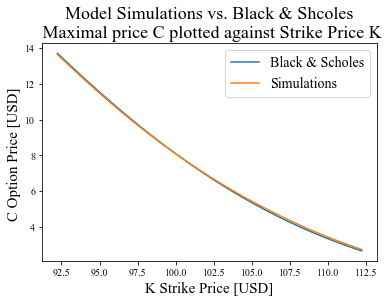

In [148]:
def option_income(S_0, K, T, r, sig, C):
    future_income = (ms_avg_pred[T] - K) * math.pow(math.e, -r * T) 
    return future_income - C

def stock_income(S_0, T, r, sig):
    future_income = ms_avg_pred[T] * math.pow(math.e, -r * T) 
    return future_income - S_0

def compare(S_0, K, T, r, sig, C):
    print("Stock Income:\t", str(stock_income(S_0, T, r, sig)))
    print("Option Income:\t", str(option_income(S_0, K, T, r, sig, C)))
                            
def black_shcoles_call(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    
    return call

def guess_max_c(preds, K, T, r, sig):
    guesses_c = []
    
    for pred in preds:
        # Say the user uses the option in T time
        # Then the income he will get will be of the form:
        future_income = (pred[T] - K) * math.pow(math.e, -r * T) 

        # Therefore the most he should pay for an option is around this value
        guesses_c.append(max(0, future_income))

    return np.mean(guesses_c)

def guess_max_c_gradually(preds, K, T, r, sig):
    guesses = []

    # Find average of each prediction up to i
    means = [np.mean(preds[:i + 1], axis=0) for i in range(len(preds))]
    
    # Guess the C from the data
    for pred in means:
        # Say the user uses the option in T time
        # Then the income he will get will be of the form:
        future_income = (pred[T] - K) * math.pow(math.e, -r * T) 
        
        # Therefore the most he should pay for an option is around this value
        guesses.append(future_income)
    return guesses

def plot_max_c(bs_c, guessed_c):
    x = list(range(len(guessed_c)))
    plt.plot(x, [bs_c] * len(guessed_c))
    plt.scatter(x, guessed_c)
    plt.show()


#real_k = close_data[future_ays]
#pred_k = ms_avg_pred[future_days]

T = 50
black_cs = []
guesses_cs = []
time_list = list(range(1, 252))

# find some relevant k's
k_list = [close_data[0] -10 +  20 * (K / 1000) for K in range(1, 1000) ]
for K in k_list: 
    
    bs_max_c = black_shcoles_call(close_data[0], K, T, DEFAULT_R, DEFAULT_SIG)
    guessed_max_c = guess_max_c(ms_preds, K, T, DEFAULT_R, DEFAULT_SIG)
    
    black_cs.append(bs_max_c)
    guesses_cs.append(guessed_max_c)
    
    
    # plot_max_c(bs_max_c, guessed_max_c)
    #compare(close_data[0], K, T, DEFAULT_R, DEFAULT_SIG, bs_max_c)
    


    
plt.plot(k_list, black_cs)
plt.plot(k_list, guesses_cs)
plt.title("Model Simulations vs. Black & Shcoles\n Maximal price C plotted against Strike Price K", fontsize=18)
plt.xlabel("K Strike Price [USD]", fontsize=15)
plt.ylabel("C Option Price [USD] ", fontsize=15)
plt.legend(["Black & Scholes", "Simulations"], fontsize=14)
plt.show()


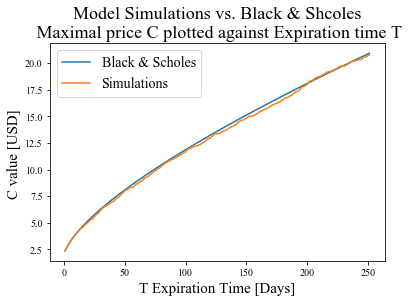

In [70]:
K = 100
black_cs = []
guesses_cs = []
time_list = list(range(1, 252))
k_list = list(range(1, 140))
for T in time_list: 
    bs_max_c = black_shcoles_call(close_data[0], K, T, DEFAULT_R, DEFAULT_SIG)
    guessed_max_c = guess_max_c(ms_preds, K, T, DEFAULT_R, DEFAULT_SIG)
    
    black_cs.append(bs_max_c)
    guesses_cs.append(guessed_max_c)
    
    
    # plot_max_c(bs_max_c, guessed_max_c)
    #compare(close_data[0], K, T, DEFAULT_R, DEFAULT_SIG, bs_max_c)

    
plt.plot(time_list, black_cs)
plt.plot(time_list, guesses_cs)
plt.title("Model Simulations vs. Black & Shcoles\n Maximal price C plotted against Expiration time T", fontsize=18)
plt.xlabel("T Expiration Time [Days]", fontsize=15)
plt.ylabel("C value [USD] ", fontsize=15)
plt.legend(["Black & Scholes", "Simulations"], fontsize=14)
plt.show()